In [2]:
import numpy as np, datetime, json, sys
import matplotlib.pyplot as plt
import time, datetime

from envs.indep_env import IndependentPricingEnvironment
from agents.indep_agent import OptimisticIndependentPricingAgent
from utils.misc import generate_curves, generate_user_ranges

In [3]:
def trial_independent_products(num_products, num_actions, actions, horizon, user_ranges_overall, L_kernel, trial_id):
    np.random.seed(trial_id)
    demands = generate_curves(num_products, num_actions=num_actions)
    # print(demands)
    # plt.figure()
    # plt.plot(actions, demands.ravel()) # works only with 1 product
    user_ranges = generate_user_ranges(num_products, user_ranges_overall[0], user_ranges_overall[1])
    # print(user_ranges)
    actions_rep = np.repeat(actions.reshape(1, -1), num_products, axis=0)
    # print(actions_rep)
    env = IndependentPricingEnvironment(num_products, num_actions, actions_rep, demands, user_ranges, seed=trial_id)
    # print("Env")
    # print(env.n_products, env.n_actions, env.actions, env.demands)
    optimal_actions, optimal_values = env.compute_optimal_actions()
    # print(optimal_actions, optimal_values)
    results_dict = {"res" : np.zeros((horizon, num_products)), "act" : np.zeros((horizon, num_products), dtype=int)}
    indep_instances = []
    for i in range(num_products): 
        indep_instances.append(OptimisticIndependentPricingAgent(actions, L_kernel, np.log(horizon)))
        # print(indep_instances[-1])
    for t in range(horizon):
        for i in range(num_products):
            results_dict["act"][t, i] = indep_instances[i].pull()
        res = env.step(results_dict["act"][t, :])
        # print(results_dict["act"][t, :])
        # print(res)
        # print(res)
        for i in range(num_products):
            indep_instances[i].update(res[i, 0], res[i, 1])
            results_dict["res"][t, i] = res[i, 1] * optimal_values[i] - res[i, 1] * actions[results_dict["act"][t, i]
                    ] * demands[i, results_dict["act"][t, i]]
    """
    test = []
    for i in range(10000):
        test.append(env.step(np.array([1, 2])))
    all_data = np.array(test).reshape(-1,2)
    sales = all_data[:,0].sum(axis=0)
    impr = all_data[:,1].sum(axis=0)
    print(sales / impr)
    test = []
    for i in range(10000):
        test.append(env.step(np.array([0, 2])))
    all_data_prods = np.array(test)
    for i in range(num_products):
        all_data = all_data_prods[:, i, :]
        sales = all_data[:,0].sum(axis=0)
        impr = all_data[:,1].sum(axis=0)
        print(sales / impr)
    """
    return results_dict

In [4]:
# Settings
num_actions = 5
num_products = 2
horizon = 100000
user_ranges_overall = [10, 30]
actions = np.linspace(0.1, 1.0, num_actions)
L_kernel = 100
num_trials = 2
dateformat = "(%Y-%b-%d %I:%M%p)"

results_dict = []
for i in range(num_trials):
    start_time = time.time()
    print(datetime.datetime.now().strftime(dateformat) + " Starting trial " + str(i+1) + " of " + str(num_trials) + ".")
    results_dict.append(trial_independent_products(num_products, num_actions, actions, horizon, user_ranges_overall, L_kernel, i))
    print(datetime.datetime.now().strftime(dateformat) + " Terminating trial " + str(i+1) + " of " + str(num_trials) + ". Elapsed time: " + str(int(time.time() - start_time)) + " sec.")

(2025-Jun-18 11:50AM) Starting trial 1 of 2.
(2025-Jun-18 11:50AM) Terminating trial 1 of 2. Elapsed time: 32 sec.
(2025-Jun-18 11:50AM) Starting trial 2 of 2.
(2025-Jun-18 11:51AM) Terminating trial 2 of 2. Elapsed time: 35 sec.


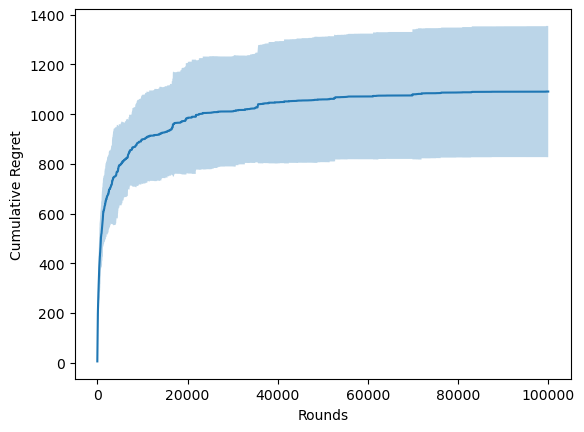

In [5]:
plt.figure()
x_plt = np.linspace(0, horizon-1, horizon, dtype=int)
aux = np.zeros((num_trials, horizon))
for i in range(num_trials):
    aux[i, :] = np.array(results_dict[i]["res"]).sum(axis=1)    
results = np.cumsum(aux, axis=1)
results_mean = np.mean(results, axis=0)
results_std = 1.96 * results.std(axis=0) / np.sqrt(num_trials)
plt.plot(x_plt, results_mean[x_plt])
plt.fill_between(x_plt, results_mean[x_plt] - results_std[x_plt], results_mean[x_plt] + results_std[x_plt], alpha=0.3)
plt.xlabel("Rounds")
plt.ylabel("Cumulative Regret")
time_print = datetime.datetime.now().strftime("(%Y-%b-%d %Ih%Mm%p)")
save_path = "results/indep_run_" + time_print
plt.savefig(save_path + ".jpg")